In [11]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
data=csvFuturesSimData()
data

2023-01-13 11:15:40 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:40 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:40 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:40 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:40 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


csvFuturesSimData object with 208 instruments

In [12]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc

In [13]:
def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds Lfast, Lslow and vol_lookback

    """
    ## price: This is the stitched price series
    ## We can't use the price of the contract we're trading, or the volatility will be jumpy
    ## And we'll miss out on the rolldown. See https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()
    if Lslow is None:
        Lslow = 4 * Lfast

    ## We don't need to calculate the decay parameter, just use the span directly

    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())

    return raw_ewmac / vol

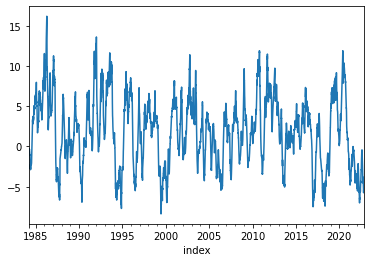

In [14]:
instrument_code='EDOLLAR'
price=data.daily_prices(instrument_code)
ewmac=calc_ewmac_forecast(price, 32, 128)
ewmac.tail(5)

from matplotlib.pyplot import show
ewmac.plot()
show()

In [15]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast = ewmac, price=price)
account.percent.stats()

[[('min', '-5.81'),
  ('max', '5.141'),
  ('median', '0'),
  ('mean', '0.01387'),
  ('std', '0.4961'),
  ('skew', '-0.2207'),
  ('ann_mean', '3.551'),
  ('ann_std', '7.938'),
  ('sharpe', '0.4474'),
  ('sortino', '0.5269'),
  ('avg_drawdown', '-11.27'),
  ('time_in_drawdown', '0.9733'),
  ('calmar', '0.09859'),
  ('avg_return_to_drawdown', '0.315'),
  ('avg_loss', '-0.317'),
  ('avg_gain', '0.3232'),
  ('gaintolossratio', '1.02'),
  ('profitfactor', '1.1'),
  ('hitrate', '0.519'),
  ('t_stat', '2.806'),
  ('p_value', '0.005024')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

3.5509868093253703

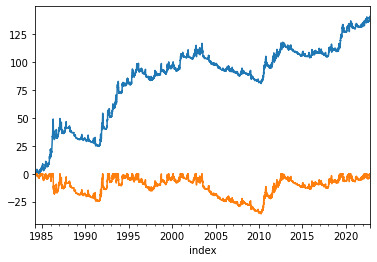

In [16]:
account.sharpe() ## get the Sharpe Ratio (annualised), and any other statistic which is in the stats list
account.curve().plot() ## plot the cumulative account curve (equivalent to account.cumsum().plot() inicidentally)
account.percent ## gives a % curve
account.percent.drawdown().plot() ## see the drawdowns as a percentage
account.weekly ## weekly returns (also daily [default], monthly, annual)
account.gross.ann_mean() ## annual mean for gross returns, also costs (there are none in this simple example)

In [17]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
data=csvFuturesSimData()

from systems.provided.rules.ewmac import ewmac_forecast_with_defaults as ewmac

2023-01-13 11:15:43 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:43 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:43 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:43 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2023-01-13 11:15:43 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


In [18]:
from systems.forecasting import Rules
my_rules=Rules(ewmac)
my_rules.trading_rules()

{'rule0': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f6c1f9dc8b0>, data: data.daily_prices (args: {}) and other_args: }

In [19]:
my_rules=Rules(dict(ewmac=ewmac))
my_rules.trading_rules()['ewmac']

TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f6c1f9dc8b0>, data: data.daily_prices (args: {}) and other_args: 

In [20]:
from systems.basesystem import System
my_system=System([my_rules], data)
my_system

System base_system with .config, .data, and .stages: rules

In [24]:
my_system.rules

Rules object with rules ewmac

In [25]:
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac").tail(5)

index
2022-10-25   -1.464627
2022-10-26   -1.491614
2022-10-27   -1.512335
2022-10-28   -1.540321
2022-10-31   -1.568499
Freq: B, Name: price, dtype: float64

In [27]:
from systems.trading_rules import TradingRule

ewmac_rule = TradingRule(ewmac)
my_rules = Rules(dict(ewmac=ewmac_rule))
ewmac_rule

TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f6c1f9dc8b0>, data: data.daily_prices (args: {}) and other_args: 

In [28]:
ewmac_8=TradingRule((ewmac, [], dict(Lfast=8, Lslow=32))) ## as a tuple (function, data, other_args) notice the empty element in the middle
ewmac_32=TradingRule(dict(function=ewmac, other_args=dict(Lfast=32, Lslow=128)))  ## as a dict
my_rules=Rules(dict(ewmac8=ewmac_8, ewmac32=ewmac_32))
my_rules.trading_rules()['ewmac32']

TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f6c1f9dc8b0>, data: data.daily_prices (args: {}) and other_args: Lfast, Lslow

In [29]:
my_system=System([my_rules], data)
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac32").tail(5)

index
2022-10-25   -1.464627
2022-10-26   -1.491614
2022-10-27   -1.512335
2022-10-28   -1.540321
2022-10-31   -1.568499
Freq: B, Name: price, dtype: float64

In [30]:
from sysdata.config.configdata import Config
my_config=Config()
my_config

Config with elements: 

In [31]:
empty_rules=Rules()
my_config.trading_rules=dict(ewmac8=ewmac_8, ewmac32=ewmac_32)
my_system=System([empty_rules], data, my_config)
print(my_system.rules.get_raw_forecast("EDOLLAR", "ewmac8"))

index
1984-03-23         NaN
1984-03-26         NaN
1984-03-27         NaN
1984-03-28         NaN
1984-03-29         NaN
                ...   
2022-10-25   -0.630358
2022-10-26   -0.555489
2022-10-27   -0.452254
2022-10-28   -0.423103
2022-10-31   -0.418735
Freq: B, Name: price, Length: 10072, dtype: float64


In [32]:
my_config.trading_rules

{'ewmac8': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f6c1f9dc8b0>, data: data.daily_prices (args: {}) and other_args: Lfast, Lslow,
 'ewmac32': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f6c1f9dc8b0>, data: data.daily_prices (args: {}) and other_args: Lfast, Lslow}

In [19]:
from systems.forecast_scale_cap import ForecastScaleCap

In [20]:
my_config.instruments=["EDOLLAR", "US10", "CORN", "SP500_micro"]

In [21]:
my_config.use_forecast_scale_estimates=True

In [22]:
fcs=ForecastScaleCap()
my_system = System([fcs, my_rules], data, my_config)
print(my_system.forecastScaleCap.get_forecast_scalar("EDOLLAR", "ewmac32").tail(5))

index
2022-05-25    8.636384
2022-05-26    8.635942
2022-05-27    8.635500
2022-05-30    8.635057
2022-05-31    8.634601
Freq: B, dtype: float64


/home/arto/anaconda3/envs/pysystemtrade/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [23]:
print(my_system.forecastScaleCap.get_forecast_scalar("EDOLLAR", "ewmac8").tail(5))

index
2022-05-25    19.375912
2022-05-26    19.376950
2022-05-27    19.377947
2022-05-30    19.378944
2022-05-31    19.380046
Freq: B, dtype: float64


In [24]:
my_config.forecast_scalars=dict(ewmac8=5.3, ewmac32=2.65)

## this parameter ensures we don't estimate:
my_config.use_forecast_scale_estimates=False

my_system=System([fcs, empty_rules], data, my_config)

print(my_system.forecastScaleCap.get_forecast_scalar("EDOLLAR", "ewmac32"))
2.65 # now a single float value

my_system.forecastScaleCap.get_capped_forecast("EDOLLAR", "ewmac32")

index
1984-03-23    2.65
1984-03-26    2.65
1984-03-27    2.65
1984-03-28    2.65
1984-03-29    2.65
              ... 
2022-05-25    2.65
2022-05-26    2.65
2022-05-27    2.65
2022-05-30    2.65
2022-05-31    2.65
Freq: B, Length: 9963, dtype: float64


index
1984-03-23         NaN
1984-03-26         NaN
1984-03-27         NaN
1984-03-28         NaN
1984-03-29         NaN
                ...   
2022-05-25   -4.917088
2022-05-26   -4.878692
2022-05-27   -4.859542
2022-05-30   -4.859542
2022-05-31   -4.903716
Freq: B, Length: 9963, dtype: float64

In [25]:

from systems.forecast_combine import ForecastCombine

combiner = ForecastCombine()
my_system = System([fcs, empty_rules, combiner], data, my_config)
my_system.combForecast.get_forecast_weights("EDOLLAR").tail(5)
my_system.combForecast.get_forecast_diversification_multiplier("EDOLLAR").tail(5)


2022-11-21 15:51:07 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'EDOLLAR'} [Warning] WARNING: No forecast weights  - using equal weights of 0.500 over all 2 trading rules in system
2022-11-21 15:51:08 {'type': 'base_system', 'stage': 'combForecast'} [Warning] You need an accounts stage in the system to estimate forecast costs for EDOLLAR ewmac32. Using costs of zero
2022-11-21 15:51:08 {'type': 'base_system', 'stage': 'combForecast'} [Warning] You need an accounts stage in the system to estimate forecast costs for EDOLLAR ewmac8. Using costs of zero


index
2022-05-25    1.0
2022-05-26    1.0
2022-05-27    1.0
2022-05-30    1.0
2022-05-31    1.0
Freq: B, dtype: float64

In [26]:
from systems.rawdata import RawData
from systems.positionsizing import PositionSizing
from systems.accounts.accounts_stage import Account
combiner = ForecastCombine()
raw_data = RawData()
position_size = PositionSizing()
my_account = Account()

## let's use naive markowitz to get more interesting results...
my_config.forecast_weight_estimate = dict(method="one_period")
my_config.use_forecast_weight_estimates = True
my_config.use_forecast_div_mult_estimates = True

combiner = ForecastCombine()
my_system = System([my_account, fcs, my_rules, combiner, position_size, raw_data], data, my_config)

## this is a bit slow, better to know what's going on
my_system.set_logging_level("on")

print(my_system.combForecast.get_forecast_weights("US10").tail(5))
print(my_system.combForecast.get_forecast_diversification_multiplier("US10").tail(5))

2022-11-21 15:51:08 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 15:51:08 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 15:51:08 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-21 15:51:08 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'US10'}  Calculating forecast weights for US10
2022-11-21 15:51:08 {'type': 'base_system', 'stage': 'combForecast'}  Calculating raw forecast weights for US10
2022-11-21 15:51:08 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'CORN', 'rule_variation_name': 'ewmac32'}  Calculating capped forecast for CORN ewmac32
2022-11-21 15:51:08 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'CORN', 'rule_variation_name': 'ewmac32'}  Calculating raw forecast CORN for ewmac32
2022-11-21 15:51:09

A little extreme, I feel. Let's use some arbitrary fixed forecast weights and diversification multiplier for now:


In [27]:
my_config.forecast_weights=dict(ewmac8=0.5, ewmac32=0.5)
my_config.forecast_div_multiplier=1.1
my_config.use_forecast_weight_estimates = False
my_config.use_forecast_div_mult_estimates = False
my_system=System([fcs, empty_rules, combiner, raw_data, position_size], data, my_config)
my_system.combForecast.get_combined_forecast("EDOLLAR").tail(5)



2022-11-21 15:51:28 {'type': 'base_system', 'stage': 'config'}  Adding config defaults
2022-11-21 15:51:28 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 15:51:28 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 15:51:28 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-21 15:51:28 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'EDOLLAR'}  Calculating combined forecast for EDOLLAR
2022-11-21 15:51:28 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'EDOLLAR', 'rule_variation_name': 'ewmac32'}  Calculating capped forecast for EDOLLAR ewmac32
2022-11-21 15:51:28 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'EDOLLAR', 'rule_variation_name': 'ewmac32'}  Calculating raw forecast EDOLLAR for ewmac32
2022-11-21 15:51:28 {'typ

index
2022-05-25   -2.188517
2022-05-26   -2.011760
2022-05-27   -1.914333
2022-05-30   -1.914333
2022-05-31   -2.021213
Freq: B, dtype: float64


If you're working through my book you'd know the next stage is deciding what level of risk to target (chapter 9) and position sizing (chapter 10).
Let's do the position scaling:




In [29]:


my_config.percentage_vol_target=25
my_config.notional_trading_capital=500000
my_config.base_currency="GBP"

my_system=System([ fcs, empty_rules, combiner, position_size, raw_data], data, my_config)

my_system.positionSize.get_subsystem_position("EDOLLAR").tail(5)


2022-11-21 16:09:40 {'type': 'base_system', 'stage': 'config'}  Adding config defaults
2022-11-21 16:09:40 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 16:09:40 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 16:09:40 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-21 16:09:40 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'EDOLLAR'}  Calculating subsystem position for EDOLLAR
2022-11-21 16:09:40 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'EDOLLAR'}  Calculating volatility scalar for EDOLLAR
2022-11-21 16:09:40 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'EDOLLAR'}  Calculating instrument value vol for EDOLLAR
2022-11-21 16:09:40 {'type': 'base_system', 'stage': 'positionSize', 'instrument_code': 'EDOLLA

index
2022-05-25   -10.852882
2022-05-26   -10.204429
2022-05-27    -9.941580
2022-05-30    -9.967849
2022-05-31   -10.554184
Freq: B, dtype: float64


The final stage we need to get positions is to combine everything into a portfolio (chapter 11).


In [30]:
from systems.portfolio import Portfolios
portfolio = Portfolios()

## Using shrinkage will speed things but - but I don't recommend it for actual trading...
my_config.use_instrument_weight_estimates = True
my_config.use_instrument_div_mult_estimates = True
my_config.instrument_weight_estimate=dict(method="shrinkage", date_method="in_sample") ## speeds things up

my_system = System([my_account, fcs, my_rules, combiner, position_size, raw_data,
                    portfolio], data, my_config)

my_system.set_logging_level("on")

print(my_system.portfolio.get_instrument_weights())
print(my_system.portfolio.get_instrument_diversification_multiplier())


2022-11-21 16:11:02 {'type': 'base_system', 'stage': 'config'}  Adding config defaults
2022-11-21 16:11:02 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 16:11:02 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 16:11:02 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-21 16:11:02 {'type': 'base_system', 'stage': 'portfolio'}  Calculating instrument weights
2022-11-21 16:11:02 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 16:11:02 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 16:11:02 {'type': 'base_system'}  Following instruments are marked as 'bad_markets':  ['BAD_EXAMPLE']
2022-11-21 16:11:02 {'type': 'base_system'}  Following instrum

Alternatively we can just make up some instrument weights, and diversification multiplier.

*Again if we really couldn't be bothered, this would default to equal weights and 1.0 respectively*



In [32]:

my_config.instrument_weights=dict(US10=.1, EDOLLAR=.4, CORN=.3, SP500_micro=.8)
my_config.instrument_div_multiplier=1.5
my_config.use_instrument_weight_estimates = False
my_config.use_instrument_div_mult_estimates = False

my_system=System([ fcs, empty_rules, combiner, position_size, raw_data, portfolio], data, my_config)

my_system.portfolio.get_notional_position("EDOLLAR").tail(5)


2022-11-21 16:12:23 {'type': 'base_system', 'stage': 'config'}  Adding config defaults
2022-11-21 16:12:23 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 16:12:23 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 16:12:23 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-21 16:12:23 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'EDOLLAR'}  Calculating notional position for EDOLLAR
2022-11-21 16:12:23 {'type': 'base_system', 'stage': 'portfolio'}  Calculating instrument weights
2022-11-21 16:12:23 {'type': 'base_system', 'stage': 'portfolio'}  Calculating raw instrument weights
2022-11-21 16:12:23 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 16:12:23 {'type': 'base_system'}  Following instrume

index
2022-05-25   -4.069831
2022-05-26   -3.826661
2022-05-27   -3.728093
2022-05-30   -3.737943
2022-05-31   -3.957819
Freq: B, dtype: float64

add just one more stage, to count our virtual profits:


In [34]:

from systems.accounts.accounts_stage import Account
accounts=Account()
my_system=System([ fcs, empty_rules, combiner, position_size, raw_data, portfolio, accounts], data, my_config)
profits=my_system.accounts.portfolio()
profits.percent.stats()


2022-11-21 16:13:04 {'type': 'base_system', 'stage': 'config'}  Adding config defaults
2022-11-21 16:13:04 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-21 16:13:04 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-21 16:13:04 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-21 16:13:04 {'type': 'base_system', 'stage': 'accounts'}  Calculating pandl for portfolio
2022-11-21 16:13:04 {'type': 'base_system', 'stage': 'positionSize'}  Getting vol target
2022-11-21 16:13:04 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'CORN'}  Calculating pandl for instrument for CORN
2022-11-21 16:13:04 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'CORN'}  Calculating notional position for CORN
2022-11-21 16:13:04 {'type': 'base_system', 'stage': 'portfolio'}  Cal

[[('min', '-5.58'),
  ('max', '2.851'),
  ('median', '0'),
  ('mean', '0.008712'),
  ('std', '0.4191'),
  ('skew', '-0.7362'),
  ('ann_mean', '2.198'),
  ('ann_std', '6.706'),
  ('sharpe', '0.3278'),
  ('sortino', '0.331'),
  ('avg_drawdown', '-4.62'),
  ('time_in_drawdown', '0.6192'),
  ('calmar', '0.09116'),
  ('avg_return_to_drawdown', '0.4759'),
  ('avg_loss', '-0.3605'),
  ('avg_gain', '0.3613'),
  ('gaintolossratio', '1.002'),
  ('profitfactor', '1.079'),
  ('hitrate', '0.5184'),
  ('t_stat', '2.348'),
  ('p_value', '0.01889')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

These are profits net of tax. You can see the gross profits and costs:



In [35]:
profits.gross.percent.stats() ## all other things work eg profits.gross.sharpe()
profits.costs.percent.stats()



/home/arto/anaconda3/envs/pysystemtrade/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/arto/anaconda3/envs/pysystemtrade/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[('min', '-0.0229'),
  ('max', '0'),
  ('median', '-0.0008557'),
  ('mean', '-0.001281'),
  ('std', '0.001694'),
  ('skew', '-4.258'),
  ('ann_mean', '-0.1355'),
  ('ann_std', '0.02711'),
  ('sharpe', '-4.998'),
  ('sortino', '-4.987'),
  ('avg_drawdown', '-2.26'),
  ('time_in_drawdown', '0.6553'),
  ('calmar', '-0.01948'),
  ('avg_return_to_drawdown', '-0.05994'),
  ('avg_loss', '-0.001294'),
  ('avg_gain', 'nan'),
  ('gaintolossratio', 'nan'),
  ('profitfactor', '0'),
  ('hitrate', '0'),
  ('t_stat', '-55.71'),
  ('p_value', '0')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]


To speed things up you can also pass a dictionary to `Config()`. To reproduce the setup we had above we'd make a dict like so:


In [37]:


from sysdata.config.configdata import Config
my_config=Config(dict(trading_rules=dict(ewmac8=ewmac_8, ewmac32=ewmac_32), instrument_weights=dict(US10=.1, EDOLLAR=.4, CORN=.3, SP500_micro=.2), instrument_div_multiplier=1.5, forecast_scalars=dict(ewmac8=5.3, ewmac32=2.65), forecast_weights=dict(ewmac8=0.5, ewmac32=0.5), forecast_div_multiplier=1.1
,percentage_vol_target=25, notional_trading_capital=500000, base_currency="GBP"))
my_config



Config with elements: base_currency, forecast_div_multiplier, forecast_scalars, forecast_weights, instrument_div_multiplier, instrument_weights, notional_trading_capital, percentage_vol_target, trading_rules

Alternatively, use a yaml file:

In [39]:

my_config=Config("systems.provided.example.simplesystemconfig.yaml")